# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "peter"
ln1 = "martigny"
fn2 = "benoît"
ln2 = "choffin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_martigny_peter_and_choffin_benoît.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn


#np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

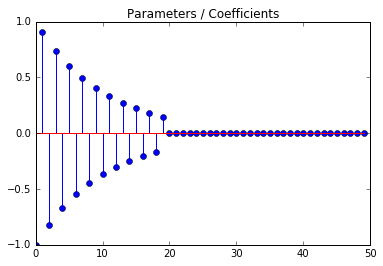

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

In [6]:
sigmoid(np.array([1, 2, 10, -np.log(2)]))

array([ 0.73105858,  0.88079708,  0.9999546 ,  0.33333333])

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [9]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""   
    aux = np.abs(x)
    result = np.sign(x) * np.maximum((aux - s*t), 0)
    return result # TODO
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    aux = np.abs(x)
    result = s * np.sum(aux)
    return result # TODO

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    result = (1/(1 + s*t)) * x
    return result # TODO
    
def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    result = (s/2) * np.sum(x ** 2)
    return result # TODO

Test functions

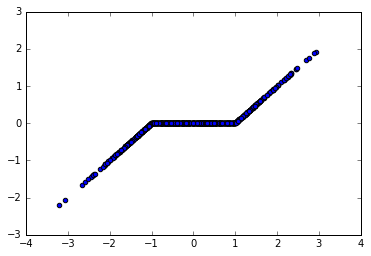

In [10]:
x = randn(1000)
x_bar = prox_lasso(x, 0.5, 2)
plt.scatter(x = x, y = x_bar)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

[-0.34193039  0.         -0.         -1.58750387  0.          0.07961415
  0.         -0.         -0.04561075 -0.         -0.11546064 -0.          0.
 -0.          0.          0.         -0.          0.93126731  0.
  1.15258082 -0.         -0.45390108  0.05597151 -0.47593998  0.         -0.
 -0.         -0.         -0.55973312 -0.09624981 -0.          0.
  0.26492596 -0.         -0.63645148  0.         -0.05412434 -0.         -0.
  0.          0.          0.         -0.         -0.         -0.          0.
 -0.         -0.          0.          0.        ]


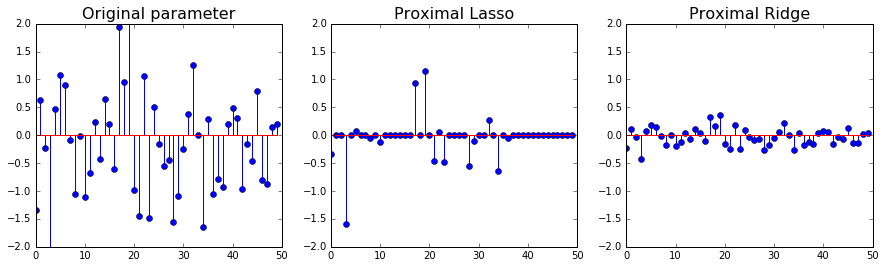

In [11]:
x = randn(50)
l_l1 = 1.
l_l2 = 5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])
print(prox_lasso(x, s = l_l1))

## Question

- Comment what you observe (1 or 2 sentences).

We observe that a relatively small lasso parameter has a significant effect on the sparsity of the coefficients, whereas it requires a bigger ridge parameter to have a similar effect. Additionnaly, the lasso shrinks certain coefficients exactly to 0, whereas the ridge only lowers the general magnitude of the coefficients, but they are not null.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [12]:
def loss_linreg(x):
    """Least-squares loss"""
    n = n_samples
    result = (1/(2*n)) * (((b - np.dot(A, x)) ** 2).sum())
    # TODO
    return result

def grad_linreg(x):
    """Leas-squares gradient"""
    n = n_samples
    result = (1/n)*np.dot(np.transpose(A), (np.dot(A, x) - b))
    # TODO
    return result

def loss_logreg(x):
    """Logistic loss"""
    n = n_samples
    result = (1/(2*n))*sum(np.log(1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) for i in range(n))
    # TODO
    return result

def grad_logreg(x):
    """Logistic gradient"""
    n = n_samples
    result = (1/(2*n))*sum((-b[i]*np.transpose(A[i, :])*np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x)))/(1 + np.exp(-b[i]*np.dot(np.transpose(A[i, :]), x))) for i in range(n))
    # TODO
    return result

# TO BE COMPLETED

In [13]:
from scipy.optimize import check_grad

In [14]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
x = coefs
print('Check the linreg gradient: ', check_grad(loss_linreg, grad_linreg, x))

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
x = coefs
print('Check the linlog gradient: ', check_grad(loss_logreg, grad_logreg, x))

Check the linreg gradient:  2.58416451436e-08
Check the linlog gradient:  1.11702643586e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [15]:
from numpy.linalg import norm

In [179]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""  
    n = A[:, 1].size
    result = (1/n) * norm(np.dot(np.transpose(A), A), 2)
    # TODO
    return result
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    n = A[:, 1].size
    result = (1/(4*n)) * norm(np.dot(np.transpose(A), A), 2)
    # TODO
    return result
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    
    #list of x
    list_x = [x0]
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
#     if verbose:
#         print("Lauching ISTA solver...")
#         print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        x = prox_g(x - step*grad_f(x), s, step)
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        list_x.append(x)
#         if k % 10 == 0 and verbose:
#             print(' | '.join([("%d" % k).rjust(8), 
#                               ("%.2e" % obj).rjust(8), 
#                               ("%.2e" % err).rjust(8)]))
    return x, objectives, errors, list_x

Test the ISTA Algorithm

In [180]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs.shape

(50,)

(1000, 50)
50
The last error measure is:  0.114378710408


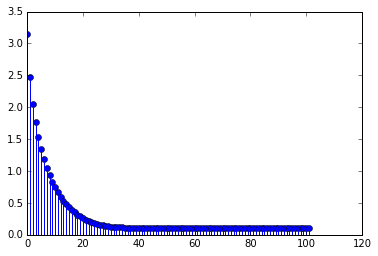

In [181]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)
print(A.shape)
x = randn(50)
print(x.size)
Z = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =100)
plt.stem(Z[2])
print('The last error measure is: ', Z[2][100])


We observe that the error doesn't converge exactly to zero, which is due to the noise introduced from the definition of A and b

The last error measure is:  0.31374984094


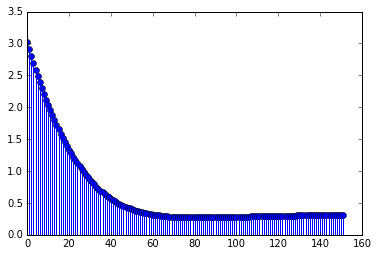

In [182]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =150)
plt.stem(Z[2])
print('The last error measure is: ', Z[2][150])

For logistic regression, we observe that the convergence is not as fast as with linear regression

In [183]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()   
    
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # List of x
    list_x = [x0]
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    
    t = 1.
    t_new = 1.
    
#     if verbose:
#         print("Lauching FISTA solver...")
#         print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        x_new = prox_g(z - step*grad_f(z), s, step)
        t_new = (1/2)*(1 + np.sqrt(1 + 4*(t**2)))
        z_new = x_new + ((t-1)/t_new)*(x_new - x)
        
        x = x_new
        t = t_new
        z = z_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        list_x.append(x)
#         if k % 10 == 0 and verbose:
#             print(' | '.join([("%d" % k).rjust(8), 
#                               ("%.2e" % obj).rjust(8), 
#                               ("%.2e" % err).rjust(8)]))
    return x, objectives, errors, list_x

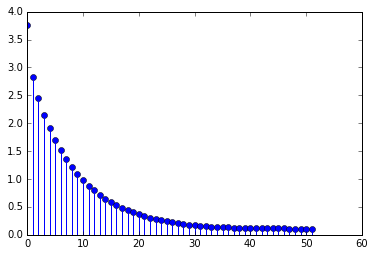

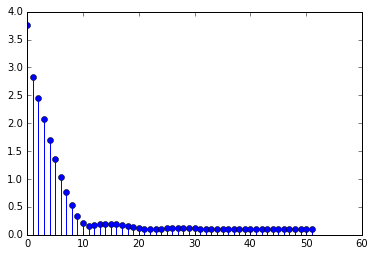

The last ista error measure is:  0.111347660379
The last fista error measure is:  0.109333663333


In [184]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Y = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)

plt.stem(Z[2])
plt.show()
plt.stem(Y[2])
plt.show()
print('The last ista error measure is: ', Z[2][50])
print('The last fista error measure is: ', Y[2][50])

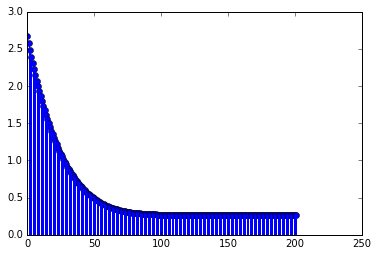

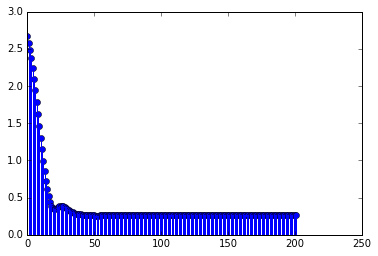

The last ista error measure is:  0.264230572873
The last fista error measure is:  0.265015590055


In [185]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =200)
Y = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =200)

plt.stem(Z[2])
plt.show()
plt.stem(Y[2])
plt.show()
print('The last ista error measure is: ', Z[2][199])
print('The last fista error measure is: ', Y[2][199])

## Algorithms comparison and numerical experiments

In [186]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

Compute minimum and minimizer

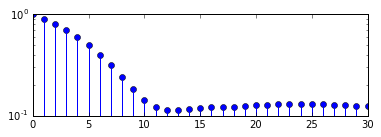

The last fista error is:  0.124919437123


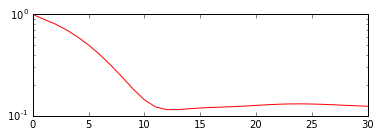

In [187]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
plt.stem(Z[2])
ax.set_yscale('log')
plt.xlim(0, 30)
plt.show()
print('The last fista error is: ', Z[2][1000])

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
plt.plot(x, Z[2], 'r')
ax.set_yscale('log')
plt.xlim(0, 30)
plt.show()

minimizer = Z[0]
min_objective = Z[1][-1]

To get the minimum of the objective function, we take the last x, given by FISTA, which is the minimizer, and the corresponding objective function, also from FISTA

Let's focus first on the distance to the minimizer.

We choose first to compute the distance for each algorithm to the reference given by the latest iteration of the FISTA with 1000 iterations. The distance used is the quadratic norm.

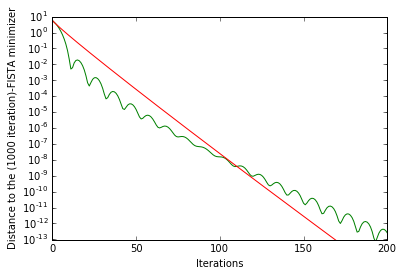

In [191]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

# We call reference the FISTA with 1000 iterations
reference = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

distance_fista = Z[3] - reference[0]
distance_to_minimizer_fista = [ridge(x,2) for x in distance_fista]
distance_ista = Y[3] - reference[0]
distance_to_minimizer_ista = [ridge(x,2) for x in distance_ista]

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, distance_to_minimizer_fista, 'g')
plt.plot(x, distance_to_minimizer_ista, 'r')
ax.set_yscale('log')
plt.xlim(0, 200)
plt.ylim(np.exp(-30), 10)
plt.xlabel('Iterations')
plt.ylabel('Distance to the (1000 iteration)-FISTA minimizer')
plt.show()

For information, we also compute the distance to the minimizer given by the last iteration of each algorithm.

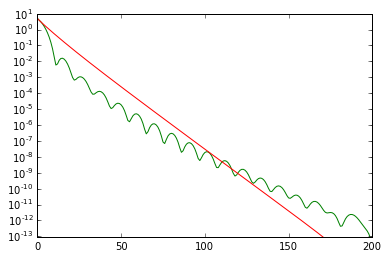

In [192]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

distance_fista = Z[3] - Z[0]
distance_to_minimizer_fista = [ridge(x,2) for x in distance_fista]
distance_ista = Y[3] - Y[0]
distance_to_minimizer_ista = [ridge(x,2) for x in distance_ista]

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, distance_to_minimizer_fista, 'g')
plt.plot(x, distance_to_minimizer_ista, 'r')
ax.set_yscale('log')
plt.xlim(0, 200)
plt.ylim(np.exp(-30), 10)
plt.show()

We observe that the FISTA algorithm converes faster than the ISTA algorithm.

Now, let's focus on the distance to the minimum.

Like before, we do both approaches.

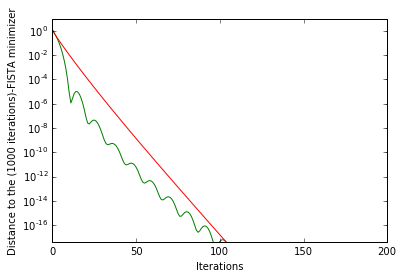

In [193]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

# We call reference the FISTA with 1000 iterations
reference = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

distance_fista = Z[1] - reference[1][-1]
distance_to_minimizer_fista = [ridge(x,2) for x in distance_fista]
distance_ista = Y[1] - reference[1][-1]
distance_to_minimizer_ista = [ridge(x,2) for x in distance_ista]

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, distance_to_minimizer_fista, 'g')
plt.plot(x, distance_to_minimizer_ista, 'r')
ax.set_yscale('log')
plt.xlim(0, 200)
plt.ylim(np.exp(-40), 10)
plt.xlabel('Iterations')
plt.ylabel('Distance to the (1000 iterations)-FISTA minimizer')
plt.show()

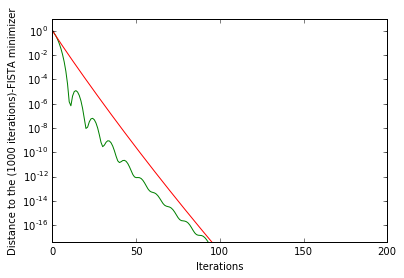

In [194]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

# We call reference the FISTA with 1000 iterations
reference = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =200)

distance_fista = Z[1] - Z[1][-1]
distance_to_minimizer_fista = [ridge(x,2) for x in distance_fista]
distance_ista = Y[1] - Y[1][-1]
distance_to_minimizer_ista = [ridge(x,2) for x in distance_ista]

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, distance_to_minimizer_fista, 'g')
plt.plot(x, distance_to_minimizer_ista, 'r')
ax.set_yscale('log')
plt.xlim(0, 200)
plt.ylim(np.exp(-40), 10)
plt.xlabel('Iterations')
plt.ylabel('Distance to the (1000 iterations)-FISTA minimizer')
plt.show()

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

# Influence of correlation

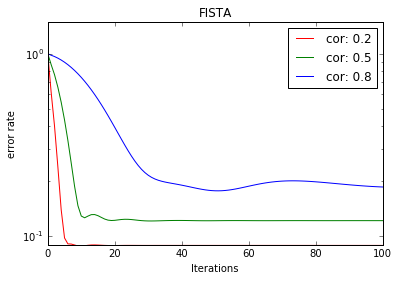

In [236]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.2)
L = lip_linreg(A)
X = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)
Y = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.8)
L = lip_linreg(A)
Z = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X[2], 'r', label = 'cor: 0.2')
plt.plot(x, Y[2], 'g', label = 'cor: 0.5')
plt.plot(x, Z[2], 'b', label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('error rate')

ax.set_yscale('log')
plt.xlim(0, 100)
plt.ylim(0.09, 1.5)
plt.title('FISTA')
plt.legend()
plt.show()

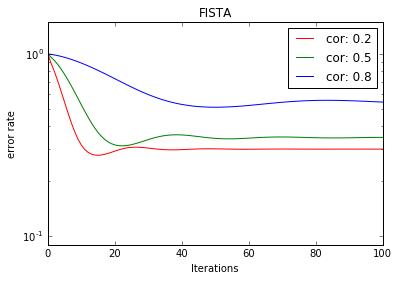

In [235]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.2)
L = lip_logreg(A)
X = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)
Y = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.8)
L = lip_logreg(A)
Z = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X[2], 'r', label = 'cor: 0.2')
plt.plot(x, Y[2], 'g', label = 'cor: 0.5')
plt.plot(x, Z[2], 'b', label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('error rate')

ax.set_yscale('log')
plt.xlim(0, 100)
plt.ylim(0.09, 1.5)
plt.title('FISTA')
plt.legend()
plt.show()

1.83561980215
3.20180256018
8.92037032596


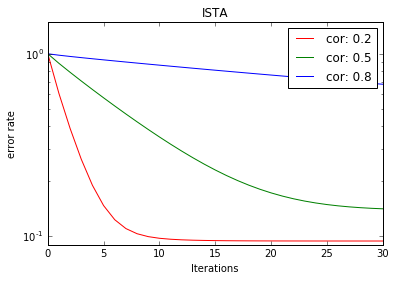

In [234]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.2)
L = lip_linreg(A)
print(L)
X = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)
print(L)
Y = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

A, b = simu_linreg(coefs, n_samples=1000, corr=0.8)
L = lip_linreg(A)
print(L)
Z = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=s, n_iter =1000)

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X[2], 'r', label = 'cor: 0.2')
plt.plot(x, Y[2], 'g', label = 'cor: 0.5')
plt.plot(x, Z[2], 'b', label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('error rate')

ax.set_yscale('log')
plt.xlim(0, 30)
plt.ylim(0.09, 1.5)
plt.title('ISTA')
plt.legend()
plt.show()

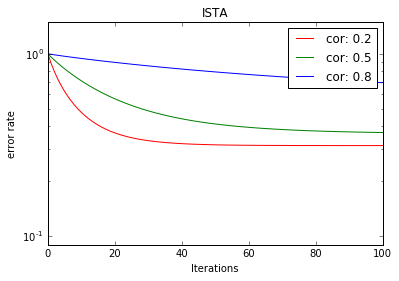

In [233]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.2)
L = lip_logreg(A)
X = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)
Y = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

A, b = simu_logreg(coefs, n_samples=1000, corr=0.8)
L = lip_logreg(A)
Z = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=s, n_iter =100)

x = np.arange(len(Z[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, X[2], 'r', label = 'cor: 0.2')
plt.plot(x, Y[2], 'g', label = 'cor: 0.5')
plt.plot(x, Z[2], 'b', label = 'cor: 0.8')
plt.xlabel('Iterations')
plt.ylabel('error rate')

ax.set_yscale('log')
plt.xlim(0, 100)
plt.ylim(0.09, 1.5)
plt.title('ISTA')
plt.legend()
plt.show()

We observe that when the correlation is higher, the algorithms convergence drops. We also observe that the Lipschitz constant increases with the correlation. In the course, we showed with Beck Teboulle and Nesterov theorem that the error is bounded linearly by L, this is why the error convergence can be slower with higher correlation.

# Influence of level of ridge penalization

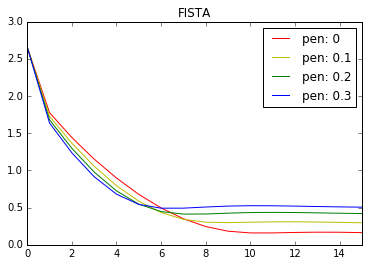

In [232]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Z1 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =50)
Z2 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =50)
Z3 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.title('FISTA')

#ax.set_yscale('log')
plt.xlim(0, 15)
plt.legend()
plt.show()

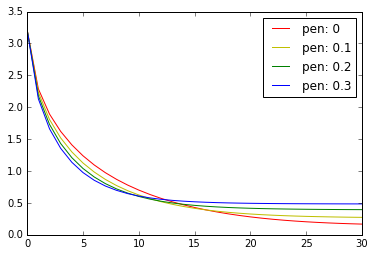

In [231]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Z1 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =50)
Z2 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =50)
Z3 = ista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('FISTA')
#ax.set_yscale('log')
plt.xlim(0, 30)
plt.legend()
plt.show()

We observe that the convergence is faster when the penalization is increased. Nevertheless, the error rate converges to a higher value when the penalization is higher.

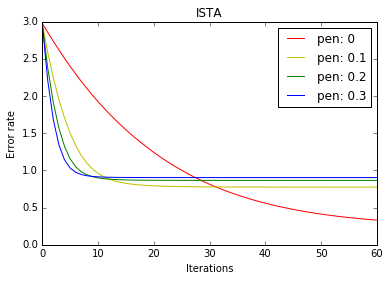

In [238]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =60)
Z1 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =60)
Z2 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =60)
Z3 = ista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =60)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('ISTA')

#ax.set_yscale('log')
plt.xlim(0, 60)
plt.legend()
plt.show()

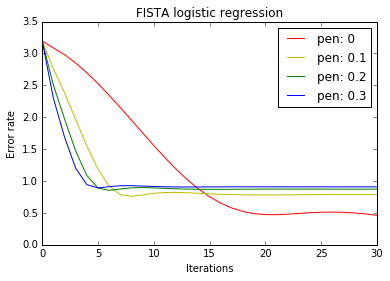

In [239]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0, n_iter =50)
Z1 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.1, n_iter =50)
Z2 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.2, n_iter =50)
Z3 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.3, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'pen: 0')
plt.plot(x, Z1[2], 'y', label = 'pen: 0.1')
plt.plot(x, Z2[2], 'g', label = 'pen: 0.2')
plt.plot(x, Z3[2], 'b', label = 'pen: 0.3')
plt.xlabel('Iterations')
plt.ylabel('Error rate')
plt.title('FISTA logistic regression')

#ax.set_yscale('log')
plt.xlim(0, 30)
plt.legend()
plt.show()

Tthe same observations apply for the logistuc regression.

# Comparison of Ridge and Lasso for performance

Let's start with linear regression:

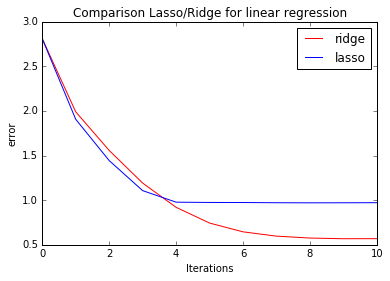

In [228]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)

x = randn(50)
Z0 = fista(x, loss_linreg, grad_linreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50)
Z1 = fista(x, loss_linreg, grad_linreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =50)

x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('error')
plt.title('Comparison Lasso/Ridge for linear regression')

#ax.set_yscale('log')
plt.xlim(0, 10)
plt.legend()
plt.show()

And then logistic regression:

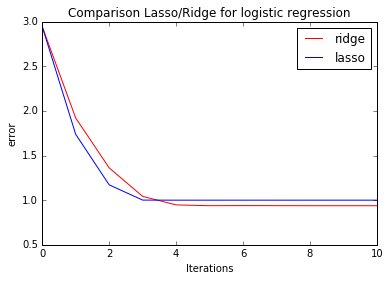

In [227]:
A, b = simu_logreg(coefs, n_samples=1000, corr=0.5)
L = lip_logreg(A)

x = randn(50)
Z0 = fista(x, loss_logreg, grad_logreg, ridge, prox_ridge, 1/L, s=0.5, n_iter =50)
Z1 = fista(x, loss_logreg, grad_logreg, lasso, prox_lasso, 1/L, s=0.5, n_iter =50)


x = np.arange(len(Z0[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, Z0[2], 'r', label = 'ridge')
plt.plot(x, Z1[2], 'b', label = 'lasso')
plt.xlabel('Iterations')
plt.ylabel('error')
plt.title('Comparison Lasso/Ridge for logistic regression')


#ax.set_yscale('log')
plt.xlim(0, 10)
plt.legend()
plt.show()

We observe that, for the same penalization parameter and both for linear and logistic regression, the errors linked with the lasso penalization are higher than the error linked with ridge penalization